In [59]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
%matplotlib inline

## Read in RV

In [29]:
rv_data = astropy.io.ascii.read("RV.txt")
fit_params = astropy.io.ascii.read("mcmc_params.txt")

In [36]:
params = {}
params_err = {}
for parameter in fit_params['symbol']:
    params[parameter] = fit_params['value'][np.where(fit_params['symbol']==parameter)[0]].data[0]
    params_err[parameter] = (fit_params['upper_error'][np.where(fit_params['symbol']==parameter)[0]].data[0]+fit_params['lower_error'][np.where(fit_params['symbol']==parameter)[0]].data[0])/2.


## Plot the best-fit model

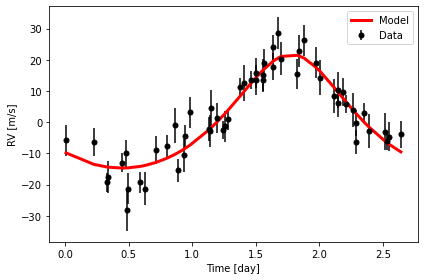

In [62]:
t = rv_data["JD"].data
if True:
    from JW_lib import RadialVelocity
    orbital_solution = [params['P'], params['TP'], params['e'], params['omega'], params['K']]
    rv = RadialVelocity(orbital_solution)
    # The parameters are period, time at periastron, eccentricity, argument of periastron, RV semi-amplitude

    # Calculate model RVs
    rvs = rv.rv_drive(t)
else:
    import radvel
#    orbital_solution = [21.218473, 2454438.751157, 0.680984, 121.36 / 360.0 * 2 * np.pi, 275.6]
    orbital_solution = [params['P'], params['TP'], params['e'], params['omega'], params['K']]
    rvs = radvel.kepler.rv_drive(t, orbital_solution, use_c_kepler_solver=False)

per = params['P']

%matplotlib inline
# Fold data and plot model against data
ind = np.argsort(t % per)
plt.errorbar(rv_data["JD"] % per, rv_data["Radial_Velocity"], rv_data["Radial_Velocity_Uncertainty"], 
             color="black", ms=5, marker="o", ls="none", label="Data")
plt.plot((t % per)[ind], rvs[ind], "r-", label="Model", lw=3)
plt.legend()
plt.xlabel("Time [day]")
plt.ylabel("RV [m/s]")
plt.tight_layout()
plt.savefig("figs/RV.pdf")

In [61]:
# Calculating the planetary mass
# The mass of the star is known from the literature Rosenthal et al. 2021
import astropy.units as u
M_star = 0.4411671425335000 * u.Msun
M_star = M_star.to(u.kg)
M_star_err = 0.0093869025567100 * u.Msun
M_star_err = M_star_err.to(u.kg)
K = params['K'] * u.m/u.s
K_err = params_err['K'] * u.m/u.s
G = 6.67408e-11 * u.m**3 / u.kg / u.s**2
sma = params['a'] * u.AU
sma = sma.to(u.m)
sma_err = params_err['a'] * u.AU
sma_err = sma_err.to(u.m)
inc = params['i'] * u.degree
sini = np.sin(inc)
inc_err = params_err['i'] * u.degree
sini_err = np.cos(inc)*inc_err
sini_err = sini_err.value

M_planet = K/sini*np.sqrt(sma*M_star/G)
M_planet_err = np.sqrt((K_err/K)**2 + (sini_err/sini)**2 + (0.5*sma_err/sma)**2 + (0.5*M_star_err/M_star)**2)*M_planet
M_planet = M_planet.to(u.Mearth)
M_planet_err = M_planet_err.to(u.Mearth)


print("The planetary mass is: ", M_planet)
print("The planetary mass error is: ", M_planet_err)

The planetary mass is:  24.61686822145652 earthMass
The planetary mass error is:  1.9673737436366752 earthMass


In [28]:
# (planet, stellar_logg, stellar_temperature, stellar_metallicity, rp_over_rs, fp_over_fs, 
#      period, sma_over_rs, eccentricity, inclination, periastron, mid_time) = plc.find_oec_parameters('hd17156b')

## Fitting RV data

In [46]:
import scipy.signal as signal
x = rv_data["JD"]
y = rv_data["Radial_Velocity"]
e = rv_data["Radial_Velocity_Uncertainty"]


## Finding the periodicity in the data

In [47]:
nout = 1e5
f = np.linspace(0.01, 10.0, int(nout)) # frequency (1/day) at which power is calculated. 
#pgram = signal.lombscargle(x, y, f, normalize=True)
pgram = signal.lombscargle(x, y, f)

Text(0, 0.5, 'Power')

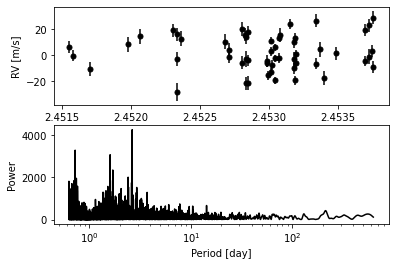

In [48]:
plt.subplot(2, 1, 1)
plt.errorbar(x, y , e, ms=5, marker="o", ls="none", color="black")
plt.xlabel("Time [BJD]")
plt.ylabel("RV [m/s]")
plt.subplot(2, 1, 2)
plt.plot(2 * np.pi / f, pgram, color="black")
plt.xscale("log")
plt.xlabel("Period [day]")
plt.ylabel("Power")

In [49]:
print("The period with the highest power is: ", 2 * np.pi / f[np.where(pgram == np.max(pgram))][0], " day")

The period with the highest power is:  2.6439321027765184  day


## Now gather information for orbital solution from references, we are ready for MCMC, which gives uncertainties for best-fit parameters.



## Define a model function with five parameters: 

## period (day), time at periastron (MJD), eccentricity, argument of periastron (degree), RV amplitude (m/s)

In [50]:
# def calcModel(params, t_stamp=None):
#     per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
#     rv = JW_lib.RadialVelocity([per, t0, ecc, omega, rv_amp])
#     return(rv.rv_drive(t_stamp))

def calcModel(params, t_stamp=None):
    per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
    return(radvel.kepler.rv_drive(t_stamp, [per, t0, ecc, omega, rv_amp], use_c_kepler_solver=False))

## Define prior function 

In [51]:
def b_range(x, b):
    if x > b:
        return -np.inf
    else:
        return 0.

def a_b_range(x, a, b):
    if x < a:
        return -np.inf
    elif x > b:
        return -np.inf
    else:
        return 0.

def log_gaussian_prior(x, x0, std):
    return((-(x - x0)**2 / (2 * (std)**2)) / 2.3)




# define data and params that are fixed and variable
#planet_name = "HD 17156 b"
planet_name = "HD 17156 b"

if planet_name == "Teegarden b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 4.8, 5.0)
    log_priors['t0']           = lambda x: a_b_range(x, 2458090.603207, 2458092.603207)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 2*np.pi)
    log_priors['K']           = lambda x: a_b_range(x, 1., 5.)
    t_stamp      = rv_tg["col1"]
    data         = rv_tg["col2"]
    data_errors  = rv_tg["col3"]

    params = [4.910122, 2458091.603207, 0.222619, 82.339257 / 360 * 2 * np.pi,2.156248]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
elif planet_name == "HD 17156 b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 20, 22)
    log_priors['t0']           = lambda x: a_b_range(x, 2454436.751157, 2454440.751157)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 360.)
    log_priors['K']           = lambda x: a_b_range(x, 100., 500.)
    t_stamp      = rv_data["JD"]
    data         = rv_data["Radial_Velocity"]
    data_errors  = rv_data["Radial_Velocity_Uncertainty"]

    params = [21.218473, 2454438.751157, 0.680984, 121.36 / 360 * 2 * np.pi, 275.6]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
else:
    print(""" Give me either "HD 17156 b" or "Teegarden b" """)


## Define likelihood function 

In [52]:
def calc_log_prob(params, data, data_errors, params_keys=params_keys, params_fixed=params_fixed, \
                  params_fixed_keys=params_fixed_keys, t_stamp=t_stamp, plot_flag=False):
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = params[i]

    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]

    # Prior calculation of all input parameters
    log_prior = 0.

    for key in params_keys:
        if not(type(params_dic[key]) is list):
            log_prior += log_priors[key](params_dic[key])
        else:
            for val in params_dic[key]:
                log_prior += log_priors[key](val)

    # Return -inf if parameters fall outside prior distribution
    if (log_prior == -np.inf):
        return -np.inf
    
    # Calculate the log-likelihood
    log_likelihood = 0.

    # Calculate the forward model, this
    # returns the wavelengths in um and flux in W/m2

    rv_model = calcModel(params_dic, t_stamp=t_stamp)

    if plot_flag:
        plt.plot(t_stamp, rv_model, "k^-", alpha=0.5, label="model")
        plt.plot(t_stamp, data, "rx-", alpha=0.5, label="data")
        plt.xlabel("Time [BJD]")
        plt.ylabel("RV [m/s]")
        plt.legend()
        plt.show()

    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(rv_model)) > 0:
        print("NaN spectrum encountered")
        return -np.inf

    # Calculate log-likelihood
    log_likelihood += -np.sum(((rv_model - data)/ \
                       data_errors)**2.)/2.

    if np.isnan(log_prior + log_likelihood):
        return -np.inf
    else:
        return log_prior + log_likelihood



## Test: calculate likelihood function

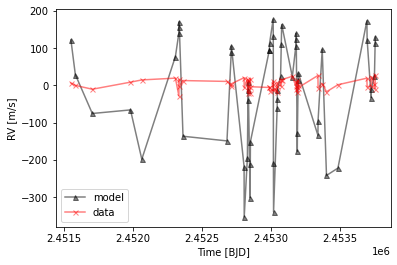

-30772.347399897735


In [53]:
print(calc_log_prob(params, data, data_errors, plot_flag=True))

## Now MCMC

In [54]:
import emcee

In [55]:
per = params[0]; e_per = 0.01
t0 = params[1]; e_t0 = 0.05
ecc = params[2]; e_ecc = 0.01
omega = params[3]; e_omega = 0.1
K = params[4]; e_K = 0.1


p_0 = params
e_p = [e_per, e_t0, e_ecc, e_omega, e_K]


ndim, nwalkers, nruns = len(p_0), 200, 1000
pos = [p_0 + e_p*np.random.randn(ndim) for i in range(nwalkers)]

import time as timer
start = timer.time()

from multiprocessing import Pool

# if pool works then use True, this option will use multi thread to increase computaional speed. Otherwise use False.
if False: 
    with Pool() as pool:

        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors), pool=pool, threads=5)
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))
else:
        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors))
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))    




emcee: Exception while calling your likelihood function:
  params: [2.12921079e+01 2.45443901e+06 9.21643609e-01 2.89787123e+00
 2.75709797e+02]
  args: (<Column name='Radial_Velocity' dtype='float64' length=55>
  6.1
 -0.3
-10.6
  8.3
 14.3
 19.1
-28.2
 15.8
 -2.8
  ...
  1.4
 19.0
 -4.4
 -1.0
 22.8
  3.2
 -8.9
 28.6, <Column name='Radial_Velocity_Uncertainty' dtype='float64' length=55>
4.5
4.1
5.2
5.5
5.7
4.9
6.7
4.9
5.5
...
4.8
4.5
3.6
5.6
5.1
4.9
4.6
5.1)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/sydneypetz/opt/anaconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/2b/tt7m4rv94lsftv5fczplqkwm0000gn/T/ipykernel_44586/785565096.py", line 31, in calc_log_prob
    rv_model = calcModel(params_dic, t_stamp=t_stamp)
  File "/var/folders/2b/tt7m4rv94lsftv5fczplqkwm0000gn/T/ipykernel_44586/3006105988.py", line 8, in calcModel
    return(radvel.kepler.rv_drive(t_stamp, [per, t0, ecc, omega, rv_amp], use_c_kepler_solver=False))
  File "/Users/sydneypetz/opt/anaconda3/lib/python3.9/site-packages/radvel/kepler.py", line 48, in rv_drive
    nu = radvel.orbit.true_anomaly(t, tp, per, e)
  File "/Users/sydneypetz/opt/anaconda3/lib/python3.9/site-packages/radvel/orbit.py", line 89, in true_anomaly
    e1 = radvel.kepler.kepler(m, eccarr)
  File "/Users/sydneypetz/opt/anaconda3/lib/python3.9/site-packages/radvel/kepler.py", line 88, in kepler
    d3 = -f

KeyboardInterrupt: 

## Check MCMC result

In [ ]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))[0:-1:10, :]


print("flat chain shape: {0}".format(samples.shape))


In [ ]:
import corner
fig = corner.corner(samples, labels=params_keys, plot_contours=True)


## Plot models with data

NameError: name 'samples' is not defined

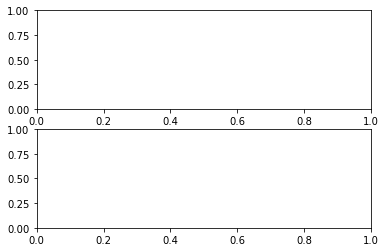

In [56]:
fig, ax = plt.subplots(2,1)

inds = np.random.randint(len(samples[:,0]), size=100)
for ind in inds:
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = samples[ind,:][i]        
    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]
    #print(params_dic["logg"])
    rv_model = calcModel(params_dic, t_stamp=t_stamp)
    ax[0].plot(t_stamp, rv_model, 'r', alpha=0.05,label='_nolegend_')
    
    
ax[0].errorbar(t_stamp, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[0].plot(t_stamp, rv_model, "r", alpha=0.5, label="Model")


# Getting median values
values = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
params = np.array(list(values))[:,0]
params_fixed = []
params_dic = {}
for i, key in enumerate(params_keys):
    params_dic[key]       = params[i]
for i, key in enumerate(params_fixed_keys):
    params_dic[key]       = params_fixed[i]


rv_model = calcModel(params_dic, t_stamp=t_stamp)
per = params_dic["per"]
ind1 = np.argsort(t_stamp % per)
ax[1].errorbar(t_stamp % per, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[1].plot((t_stamp % per)[ind1], rv_model[ind1], "r", alpha=0.5,label='Model', lw=3)

ax[1].set_xlabel("Time [BJD]", fontsize=15)
ax[0].set_ylabel("RV [m/s]", fontsize=15)
ax[1].set_ylabel("RV [m/s]", fontsize=15)

plt.gca().tick_params(labelsize=15)
ax[1].legend(fontsize=15)
# plt.tight_layout()
# plt.savefig("model_data.png")

In [ ]:
print(limb_darkening_coefficients)